<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<span>
<h2>Eliminación de ruido en imagenes de resonancia magnetica, mediante red neuronal convolucional CNN </h2> 
</span>

Gradiente, funcion de perdida con respecto a los pesos en la red, el caul se calcula utilizando la propragacion hacia atras.

Problema de fuga de gradiente: Es el problema que causa mayor dificultad a una red neuronal su entrenamiento, este problema involucra los pesos de las capas anteriores, durante el entrenamiento el gradiente estocastico SGD trabaja para calcular el gradiente de perdida con respecto a los pesos de la red, el problema es que ese gradiente muchas veces se vueleve realmente muy pequeño, por lo cual el gradiente se desvanece. El problema con un gradiente pequeño es que una vez se calcula el SGD con un peso en particular, por ejemplo 0.29 se usa este valor para actualizar el peso de alguna manera que es proporcional al gradiente, y si el gradiente es muy pequeño esa actualizacion tambien lo sera, al moverse y actualizarse este valor varias veces en la red no aportara a la funcion de perdida y se atasca y afecta la capacidad de aprendizaje de la red.

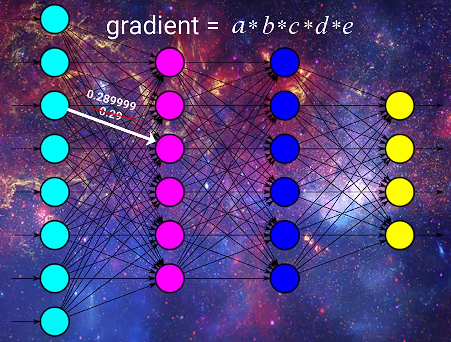
<p style="text-align:center;">
    Desvanecimiento de gradiente <br/>
    <b>Fuente:</b> <a href="https://www.youtube.com/watch?v=qO_NLVjD6zE&t=24s">Referencia <a/>
    </p>

El Problema de fuga de gradiente por desvanecimiento o explosion del gradiente es un problema general de entramiento de redes neuronale, el cual se ha atacado con diferentes tecnicas

## Instalar librerías

In [1]:
import warnings
warnings.simplefilter('ignore', category=FutureWarning)

In [ ]:
pip install tf-nightly

In [ ]:
pip install h5py

In [ ]:
pip install scikit-learn

In [ ]:
!pip uninstall tensorflow-directml

In [ ]:
!pip install matplotlib

In [ ]:
!pip install opencv-python

In [ ]:
!pip install pillow

In [2]:
import sys
from PIL import Image
sys.modules['Image'] = Image 

## Importar librerías

In [3]:
import warnings
warnings.simplefilter('ignore', category=FutureWarning)
 
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import shutil
import random
import glob
import matplotlib.pyplot as plt
import cv2
import datetime
import time
import numpy as np
from sklearn.metrics import plot_confusion_matrix

import os.path
from tensorflow.keras import Model, optimizers
from tensorflow.keras.applications import xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

Using TensorFlow backend.


## Configurar GPU con TensorFlow

In [4]:
tensorflow.test.is_gpu_available()
print("Num GPUs available", len(tensorflow.config.experimental.list_physical_devices('GPU')))

print(tensorflow.test.gpu_device_name())
print(tensorflow.test.is_gpu_available())

Num GPUs available 0
/device:DML:0
True


## Preparacion de imagenes

### Definir conjuntos de datos

#### Definir variables de entrenamiento, validacion y prueba

In [4]:
# Entrenamiento
path_train = 'D:/ADNI - IDA/ADNI1_Complete 1Yr 1.5T/ADNI-PRE-PROCESAMIENTO/ENTRENAMIENTO/' 

# Validacion
path_val = 'D:/ADNI - IDA/ADNI1_Complete 1Yr 1.5T/ADNI-PRE-PROCESAMIENTO/VALIDACION/' 

# Pruebas
path_test = r'D:/ADNI - IDA/ADNI1_Complete 1Yr 1.5T/ADNI-PRE-PROCESAMIENTO/PRUEBA/'

### Definir conjuntos de datos en formato KERAS

In [5]:
# Generacion de lotes de datos para modelo en Keras en formato vgg16

img_width = 224
img_height = 224
batch_size = 10


# Entrenamiento
train_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.resnet.preprocess_input) \
    .flow_from_directory(directory=path_train,
                         target_size=(img_width,img_height),
                         classes=['AD','CN','MCI'],
                         batch_size=batch_size)

# Validacion
valid_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.resnet.preprocess_input) \
    .flow_from_directory(directory=path_val,
                         target_size=(img_width,img_height),
                         classes=['AD','CN','MCI'],
                         batch_size=batch_size)

# Pruebas
test_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.resnet.preprocess_input) \
    .flow_from_directory(directory=path_test,
                         target_size=(img_width,img_height),
                         classes=['AD','CN','MCI'],
                         batch_size=batch_size, 
                         shuffle=False)

Found 5343 images belonging to 3 classes.
Found 1265 images belonging to 3 classes.
Found 63 images belonging to 3 classes.


In [8]:
assert train_batches.n == 5343 
assert valid_batches.n == 1265  
assert test_batches.n == 63
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3 

In [7]:
imgs, labels = next(train_batches)

In [8]:
"""Esta funcion mostrara imagenes en un grid con 1 fila y 10 columnas

Parameters
----------
list : numpy.ndarray
"""

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes =  axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img, cmap='gray', vmin=0, vmax=255)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [9]:
imgs[0].shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

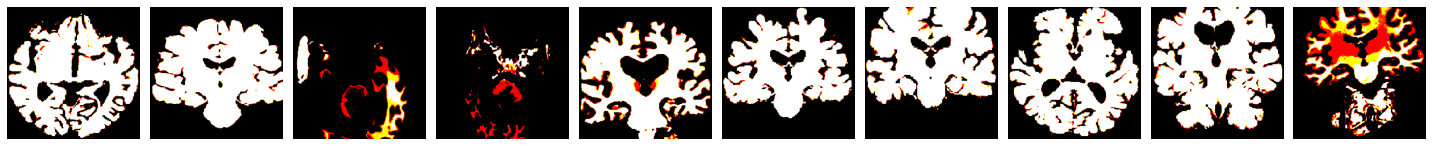

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [10]:
plotImages(imgs)
print(labels)

## Construccion y entrenamiento del modelo CNN - ResNet152

In [12]:
with tensorflow.device('DML'):
    IMG_SHAPE = (224, 224, 3)
    base_model = tensorflow.keras.applications.resnet.ResNet152(input_shape=IMG_SHAPE, 
                                                                   include_top=False,
                                                                   weights='imagenet',
                                                                   pooling='avg')
    base_model.trainable = False

    inputs = tensorflow.keras.layers.Input(IMG_SHAPE)
    x = base_model(inputs)
    x = tensorflow.keras.layers.Dense(128, activation='relu')(x)
    x = tensorflow.keras.layers.Dropout(0.2)(x)
    prediction  = tensorflow.keras.layers.Dense(3, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=prediction)
    model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152 (Model)            (None, 2048)              58370944  
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 58,633,603
Trainable params: 262,659
Non-trainable params: 58,370,944
_________________________________________________________________


 ## Entrenamiento del modelo ResNet152

In [13]:
with tensorflow.device('DML'):
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()  

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152 (Model)            (None, 2048)              58370944  
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 58,633,603
Trainable params: 262,659
Non-trainable params: 58,370,944
_________________________________________________________________


In [14]:
with tensorflow.device('DML'):
    
    from keras.callbacks import EarlyStopping
    
    earlystopper = EarlyStopping(monitor='val_loss',
                             min_delta=0, 
                             patience=5, # maximo epochs
                             verbose=1,
                             restore_best_weights=True,
                             mode='auto')
    
    model.fit(x=train_batches,
                  validation_data=valid_batches,
                  epochs=10,
                  verbose=2,
                  callbacks = [earlystopper])

Epoch 1/10
Epoch 1/10
167/167 - 114s - loss: 1.0910 - acc: 0.4286 - val_loss: 1.3594 - val_acc: 0.3794
Epoch 2/10
Epoch 1/10
167/167 - 107s - loss: 0.9820 - acc: 0.5132 - val_loss: 1.6826 - val_acc: 0.3478
Epoch 3/10
Epoch 1/10
167/167 - 108s - loss: 0.9232 - acc: 0.5594 - val_loss: 1.4975 - val_acc: 0.3573
Epoch 4/10
Epoch 1/10
167/167 - 109s - loss: 0.8770 - acc: 0.5811 - val_loss: 1.3519 - val_acc: 0.3692
Epoch 5/10
Epoch 1/10
167/167 - 110s - loss: 0.8376 - acc: 0.6130 - val_loss: 1.2525 - val_acc: 0.3802
Epoch 6/10
Epoch 1/10
167/167 - 110s - loss: 0.8017 - acc: 0.6350 - val_loss: 1.3614 - val_acc: 0.3731
Epoch 7/10
Epoch 1/10
167/167 - 110s - loss: 0.7738 - acc: 0.6556 - val_loss: 1.3338 - val_acc: 0.3850
Epoch 8/10
Epoch 1/10
167/167 - 109s - loss: 0.7457 - acc: 0.6687 - val_loss: 1.3951 - val_acc: 0.3739
Epoch 9/10
Epoch 1/10
167/167 - 109s - loss: 0.7198 - acc: 0.6850 - val_loss: 1.4320 - val_acc: 0.3747
Epoch 10/10
Epoch 1/10
167/167 - 109s - loss: 0.6963 - acc: 0.7015 - val_

 ## Predicción con conjunto de pruebas

In [15]:
test_labels = test_batches.classes

In [16]:
predictions = model.predict(x = test_batches, verbose = 0)

In [17]:
cm = confusion_matrix(y_true = test_batches.classes, 
                      y_pred = np.argmax(predictions, axis=-1))

In [18]:
test_batches.class_indices

{'AD': 0, 'CN': 1, 'MCI': 2}

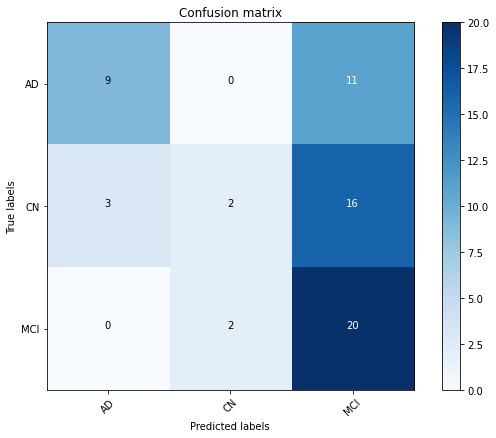

In [19]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    """
    arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """
     
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()
    
    
    
# a tuple for all the class names
target_names = ('AD', 'CN', 'MCI')
plot_confusion_matrix(cm, target_names)

In [ ]:
## Visualizar resultados del entrenamiento

In [20]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

print(acc)
print(val_acc)
print(loss)
print(val_loss)

[0.42859817, 0.5131948, 0.5594235, 0.5811342, 0.6129515, 0.63503647, 0.65562415, 0.66872543, 0.6850084, 0.70147854]
[0.37944663, 0.3478261, 0.35731223, 0.36916995, 0.38023713, 0.3731225, 0.38498023, 0.37391305, 0.37470356, 0.42924902]
[1.0910267244000214, 0.9819618570610488, 0.9231715484681077, 0.8769639119458471, 0.837555764086479, 0.8016787316275741, 0.7738412159805148, 0.7456795761876621, 0.7197893071705631, 0.6962552495536433]
[1.3593659311532975, 1.6826348096132278, 1.4974727302789688, 1.3519369900226592, 1.252532185614109, 1.361387312412262, 1.3337908178567885, 1.3950795769691466, 1.4320437014102936, 1.2214957132935524]


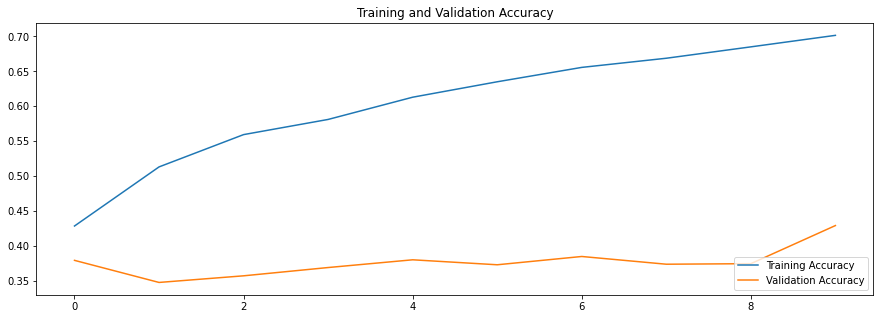

In [22]:
epochs_ft = 22
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

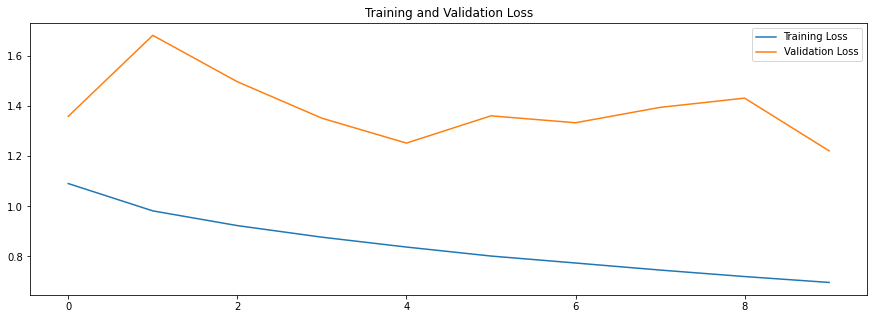

In [23]:
plt.figure(figsize=(15, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
y_true = test_batches.classes
y_pred = np.argmax(predictions, axis=-1)
target_names = ('AD', 'CN', 'MCI')

print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          AD       0.75      0.45      0.56        20
          CN       0.50      0.10      0.16        21
         MCI       0.43      0.91      0.58        22

    accuracy                           0.49        63
   macro avg       0.56      0.48      0.43        63
weighted avg       0.55      0.49      0.43        63



---
---
---

## Construcción y construir afinar el modelo CNN - RestNet152 (Modelo afinado)

In [25]:
# Agregar la base de la parte superior del modelo (top)

# nb_classes = 3

# def add_top(base):
#     x = base.output

#     # Capa de grupo de promedio global
#     x = GlobalAveragePooling2D()(x)

#     x = tensorflow.keras.layers.Dense(64, activation='relu')(x)
#     x = tensorflow.keras.layers.Dropout(0.2)(x)
    
#     # Capa regular densamente conectada
#     x = Dense(512, activation='relu')(x)

#     # Capa de salida
#     predictions = Dense(nb_classes, activation='softmax')(x)

#     return Model(inputs = base.input, outputs= predictions)

In [26]:
# # Modelo de configuración afinado
# def setup_model(model, trainable):
#     # Congelar las capas no entrenables de la base del modelo
#     for layer in model.layers[:(len(model.layers) - trainable)]:
#         layer.trainable = False

#     for layer in model.layers[(len(model.layers) - trainable):]:
#         layer.trainable = True

#     model.compile(
#         loss='categorical_crossentropy',
#         # Tasa de entrenamiento más lenta para el ajuste fino
#         optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
#         # optimizer=Adam(learning_rate=0.0001),
#         metrics=['accuracy']
#     )
    
#     return model

In [6]:
#https://github.com/krishnaik06/Transfer-Learning/blob/master/face_Recognition.py
with tensorflow.device('DML'):
    IMG_SHAPE = (224, 224, 3)
    base_model = tensorflow.keras.applications.resnet.ResNet152(input_shape=IMG_SHAPE, 
                                                                   include_top=False,
                                                                   weights='imagenet',
                                                                   pooling='avg')
    base_model.trainable = False

    inputs = tensorflow.keras.layers.Input(IMG_SHAPE)
    x = base_model(inputs)
    x = tensorflow.keras.layers.Dense(128, activation='relu')(x)
    x = tensorflow.keras.layers.Dropout(0.5)(x)
    prediction  = tensorflow.keras.layers.Dense(3, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=prediction)
    model.summary()
    

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152 (Model)            (None, 2048)              58370944  
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 58,633,603
Trainable params: 262,659
Non-trainable params: 58,370,944
_________________________________________________________________


In [7]:
with tensorflow.device('DML'):
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy'])

In [ ]:
model.summary()

In [8]:
# Afinar la modelo

epochs_ft = 30

with tensorflow.device('DML'):
    earlystopper = EarlyStopping(monitor='val_loss',
                             min_delta=0, 
                             patience=10, # maximo epochs
                             verbose=1,
                             restore_best_weights=True,
                             mode='auto')
    
    model.fit_generator(train_batches,
                        epochs=epochs_ft,
                        validation_data=valid_batches,
                        verbose=2,
                        callbacks = [earlystopper])

Epoch 1/30
Epoch 1/30
535/535 - 168s - loss: 1.1051 - acc: 0.3975 - val_loss: 1.1961 - val_acc: 0.3565
Epoch 2/30
Epoch 1/30
535/535 - 161s - loss: 1.0221 - acc: 0.4692 - val_loss: 1.2308 - val_acc: 0.4016
Epoch 3/30
Epoch 1/30
535/535 - 164s - loss: 0.9894 - acc: 0.4920 - val_loss: 1.2395 - val_acc: 0.3850
Epoch 4/30
Epoch 1/30
535/535 - 157s - loss: 0.9513 - acc: 0.5306 - val_loss: 1.2568 - val_acc: 0.3708
Epoch 5/30
Epoch 1/30
535/535 - 158s - loss: 0.9346 - acc: 0.5394 - val_loss: 1.4587 - val_acc: 0.3399
Epoch 6/30
Epoch 1/30
535/535 - 157s - loss: 0.9022 - acc: 0.5641 - val_loss: 1.2312 - val_acc: 0.3842
Epoch 7/30
Epoch 1/30
535/535 - 158s - loss: 0.8860 - acc: 0.5869 - val_loss: 1.3349 - val_acc: 0.3668
Epoch 8/30
Epoch 1/30
535/535 - 158s - loss: 0.8679 - acc: 0.5912 - val_loss: 1.2590 - val_acc: 0.4016
Epoch 9/30
Epoch 1/30
535/535 - 161s - loss: 0.8518 - acc: 0.5967 - val_loss: 1.3788 - val_acc: 0.3984
Epoch 10/30
Epoch 1/30
535/535 - 160s - loss: 0.8428 - acc: 0.6058 - val_

## Predicción modelo afinado MobileNet (Modelo afinado)

In [12]:
predictions = model.predict(x=test_batches, verbose=0)

In [13]:
cm = confusion_matrix(y_true = test_batches.classes, 
                      y_pred = np.argmax(predictions, axis=-1))

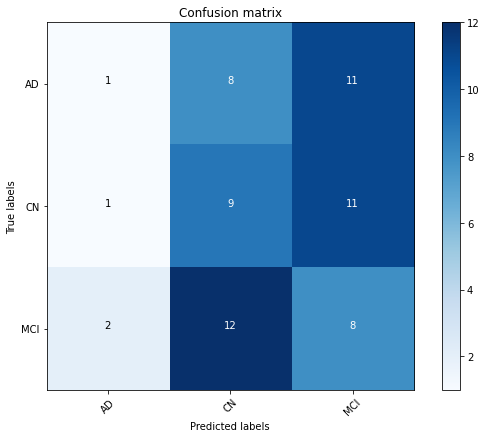

In [14]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    """
    arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """
     
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()

target_names = ('AD', 'CN', 'MCI')
plot_confusion_matrix(cm, target_names)

## Visualizar resultados del entrenamiento (Modelo afinado)

In [15]:
print(model.history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [16]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

print(acc)
print(val_acc)
print(loss)
print(val_loss)

[0.39752948, 0.46921206, 0.49204567, 0.5306008, 0.53939736, 0.56410253, 0.5869362, 0.5912409, 0.59666854, 0.60583943, 0.62156093]
[0.35652173, 0.40158102, 0.38498023, 0.370751, 0.33992094, 0.38418972, 0.3667984, 0.40158102, 0.39841896, 0.41027668, 0.40790513]
[1.1051866737126903, 1.0217204461846485, 0.9891508060427121, 0.9513602746507993, 0.9345097878263524, 0.9017582512874628, 0.8860811002353102, 0.8675995730916458, 0.8512994395577682, 0.8425669580413544, 0.8240892913777486]
[1.1960811938826494, 1.2308068740086293, 1.2394677710345412, 1.256842139668352, 1.4586555249109043, 1.2311979400830007, 1.334869778531743, 1.2590053095592288, 1.3787885674341458, 1.4429113606768331, 1.3426636631094564]


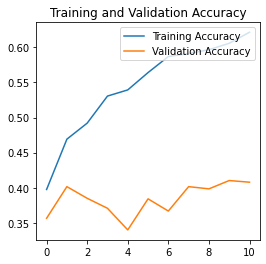

In [21]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs_range = range(11)

plt.figure(figsize=(4, 4))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.show()

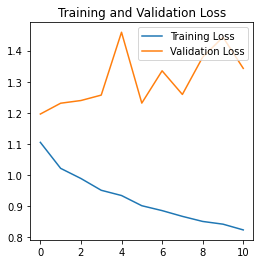

In [22]:
plt.figure(figsize=(4, 4))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
from sklearn.metrics import classification_report

y_true = test_batches.classes
y_pred = np.argmax(predictions, axis=-1)
target_names = ('AD', 'CN', 'MCI')

print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          AD       0.25      0.05      0.08        20
          CN       0.31      0.43      0.36        21
         MCI       0.27      0.36      0.31        22

    accuracy                           0.29        63
   macro avg       0.28      0.28      0.25        63
weighted avg       0.28      0.29      0.25        63



# Referencias bibliográficas

In [ ]:
https://keras.io/api/preprocessing/image/

https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images

https://towardsdatascience.com/alzheimer-diagnosis-with-deep-learning-a-survey-265406fa542a

https://www.youtube.com/watch?v=3V9YFPfgyAY

In [ ]:
https://github.com/Yale-Deep-Learning-for-Alzheimers/Alzheimers-DL-Network

In [ ]:
https://www.kaggle.com/code/muneebkhurram/alzheimer-mri-classification

0. Image Preparation for Convolutional Neural Networks with TensorFlow's Keras API
https://www.youtube.com/watch?v=_L2uYfVV48I&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=10

0.1 Data Augmentation with TensorFlow's Keras API
https://www.youtube.com/watch?v=WSvpLUietIM&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=14

1.Keras with TensorFlow - Data Processing for Neural Network Training
https://www.youtube.com/watch?v=3FwGDUD_ZuQ&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=3

2.Build and Train a Convolutional Neural Network with TensorFlow's Keras API
https://www.youtube.com/watch?v=3V9YFPfgyAY&t=326s

3.Keras with TensorFlow Prerequisites - Getting Started With Neural Networks
https://www.youtube.com/watch?v=e47ISlpYFok

4.Train a Fine-Tuned Neural Network with TensorFlow's Keras API
https://www.youtube.com/watch?v=TguZ0WK0orQ

5.Create a Confusion Matrix for Neural Network Predictions
https://www.youtube.com/watch?v=VYGVOwlT4oE&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=9

6.MobileNet Image Classification with TensorFlow's Keras API
https://www.youtube.com/watch?v=5JAZiue-fzY&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=19

7.Save and Load a Model with TensorFlow's Keras API
https://www.youtube.com/watch?v=8Nl-of5C3uA&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=10

https://keras.io/api/applications/

https://note.nkmk.me/python-tensorflow-keras-applications-pretrained-models/